## BUSI dataset processing

In [24]:
import os
import clip
import busi
print(os.path.exists("saved_models/fine_tuned_clip_busi.pt"))

True


In [25]:
import os

folder = 'data/Dataset_BUSI_with_GT'
classes = ['benign', 'malignant', 'normal']
image_paths = []
labels = []
mask_paths = []

for label_idx, class_name in enumerate(classes):
    class_folder = os.path.join(folder, class_name)
    for fname in os.listdir(class_folder):
        if fname.endswith('.png') and '_mask' not in fname:
            image_path = os.path.join(class_folder, fname)
            base_name = fname.replace('.png', '')
            mask_filename = f"{base_name}_mask.png"
            mask_path = os.path.join(class_folder, mask_filename)
            
            image_paths.append(image_path)
            labels.append(label_idx)
            mask_paths.append(mask_path)

print(f"Found {len(image_paths)} original images in total.")

Found 780 original images in total.


In [26]:
## get embeddings

Successfully loaded fine-tuned model from: saved_models/fine_tuned_clip_busi.pt


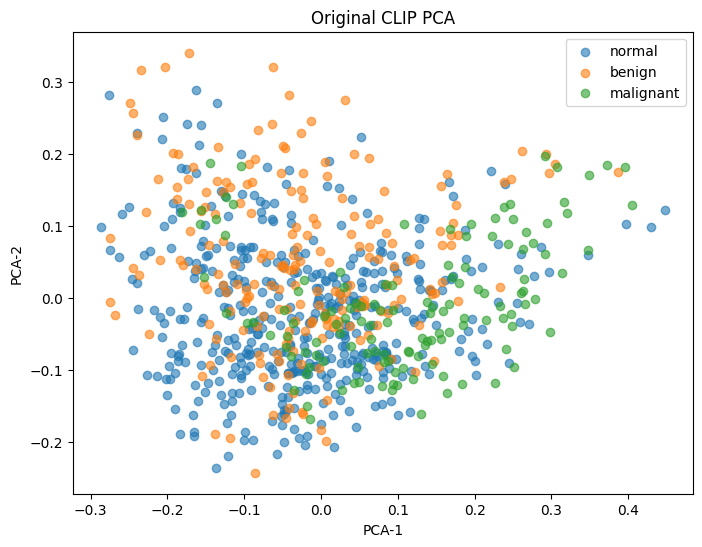

In [27]:
import os
import torch
from PIL import Image
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import clip
from busi import CLIPFineTuner, load_fine_tuned_model

# --------- Setup ---------
device = "cuda" if torch.cuda.is_available() else "cpu"
class_names = ["normal", "benign", "malignant"]

# Paths
model_path = "saved_models/fine_tuned_clip_busi.pt"

# --------- Load CLIP ---------
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
clip_model.to(device)

# --------- Fine-tuner Setup ---------
# Set up fine-tuner and load checkpoint
tuner = CLIPFineTuner(clip_model, len(class_names), device)
tuner, _, _ = load_fine_tuned_model(
    tuner,
    path=model_path,
    device=device
)
if tuner is None:
    raise RuntimeError("Could not load fine-tuned model. Check model_path and checkpoint.")

tuner.clip_model.eval()
tuner.clip_model.to(device)

# --------- Image Paths and Labels ---------
# You should have image_paths and labels ready! Example:
# from your earlier code (assume you ran this already):
# image_paths = [...]
# labels = [...]

def get_clip_embeddings(model, image_paths, preprocess):
    embeddings = []
    with torch.no_grad():
        for path in image_paths:
            image = preprocess(Image.open(path)).unsqueeze(0).to(device)
            emb = model.encode_image(image)
            emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.cpu().numpy().flatten())
    return np.stack(embeddings)

# --------- Extract Embeddings ---------
embeddings_orig = get_clip_embeddings(clip_model, image_paths, preprocess)
embeddings_ft = get_clip_embeddings(tuner.clip_model, image_paths, preprocess)

# --------- Visualization ---------
def plot_embeddings(embeddings, labels, class_names, title):
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        idx = np.array(labels) == i
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=class_name, alpha=0.6)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.title(title)
    plt.legend()
    plt.show()

plot_embeddings(embeddings_orig, labels, class_names, "Original CLIP PCA")

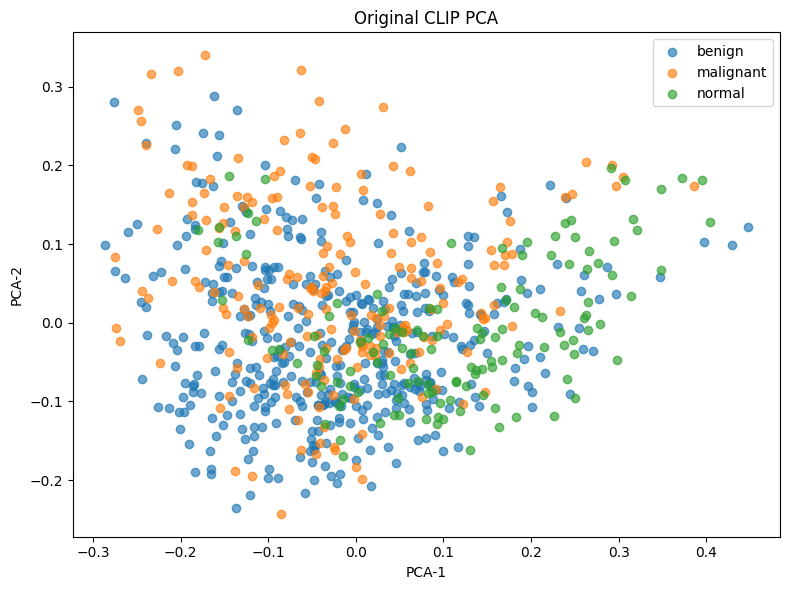

Example image: data/Dataset_BUSI_with_GT\benign\benign (1).png
Corresponding mask: data/Dataset_BUSI_with_GT\benign\benign (1)_mask.png


In [28]:
def get_clip_embeddings(model, image_paths, preprocess):
    embeddings = []
    with torch.no_grad():
        for path in image_paths:
            image = preprocess(Image.open(path)).unsqueeze(0).to(device)
            emb = model.encode_image(image)
            emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.cpu().numpy().flatten())
    return np.stack(embeddings)
embeddings_orig = get_clip_embeddings(clip_model, image_paths, preprocess)
embeddings_ft = get_clip_embeddings(tuner.clip_model, image_paths, preprocess)
# ----------- Visualization Function -----------
def plot_embeddings(embeddings, labels, class_names, title):
    pca = PCA(n_components=2)
    emb_2d = pca.fit_transform(embeddings)
    plt.figure(figsize=(8, 6))
    for i, class_name in enumerate(class_names):
        idx = np.array(labels) == i
        plt.scatter(emb_2d[idx, 0], emb_2d[idx, 1], label=class_name, alpha=0.65)
    plt.xlabel("PCA-1")
    plt.ylabel("PCA-2")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_embeddings(embeddings_orig, labels, classes, "Original CLIP PCA") 
# ----------- Show sanity check for masks -----------
print(f"Example image: {image_paths[0]}")
print(f"Corresponding mask: {mask_paths[0]}")


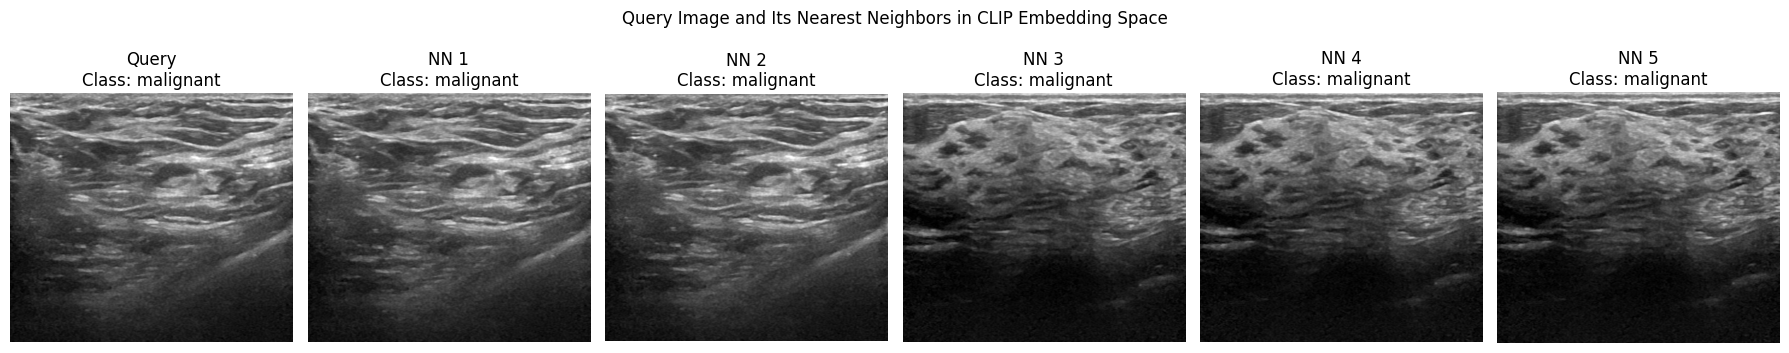

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt

# Choose which embedding space to analyze
embeddings = embeddings_orig  # frozen CLIP; use embeddings_ft for fine-tuned encoder if available

def show_nearest_neighbors(query_idx, embeddings, image_paths, labels, class_names, k=5):
    # Compute cosine similarity (the higher, the more similar)
    similarities = cosine_similarity([embeddings[query_idx]], embeddings)[0]
    
    # Exclude the query itself
    similarities[query_idx] = -1
    nn_indices = similarities.argsort()[-k:][::-1]  # Top k neighbors (excluding self)
    
    # Plot
    fig, axes = plt.subplots(1, k+1, figsize=(3*(k+1), 4))
    
    # Show the query image
    img = Image.open(image_paths[query_idx])
    axes[0].imshow(img)
    axes[0].set_title(f"Query\nClass: {class_names[labels[query_idx]]}")
    axes[0].axis('off')
    
    # Show the k nearest neighbors
    for i, idx in enumerate(nn_indices):
        neighbor_img = Image.open(image_paths[idx])
        axes[i+1].imshow(neighbor_img)
        axes[i+1].set_title(f"NN {i+1}\nClass: {class_names[labels[idx]]}")
        axes[i+1].axis('off')
    
    plt.suptitle("Query Image and Its Nearest Neighbors in CLIP Embedding Space")
    plt.tight_layout()
    plt.show()

# Pick a random image to inspect, or set the index manually
import random
query_idx = random.randint(0, len(image_paths)-1)
show_nearest_neighbors(query_idx, embeddings, image_paths, labels, class_names, k=5)

In [20]:
with torch.no_grad():
    emb_tensor = torch.tensor(embeddings, dtype=torch.float32).to(device)
    logits = tuner.classifier(emb_tensor)  # (num_samples, num_classes)
    preds = logits.argmax(dim=1).cpu().numpy()

In [21]:
from sklearn.decomposition import PCA
logits_2d = PCA(n_components=2).fit_transform(logits.cpu().numpy())

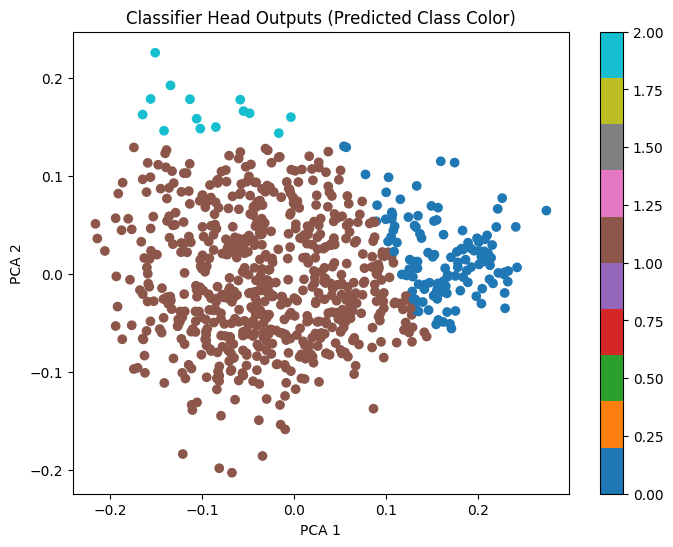

In [22]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,6))
plt.scatter(logits_2d[:,0], logits_2d[:,1], c=preds, cmap='tab10', label='Predicted')
plt.xlabel("PCA 1"); plt.ylabel("PCA 2")
plt.title("Classifier Head Outputs (Predicted Class Color)")
plt.colorbar()
plt.show()

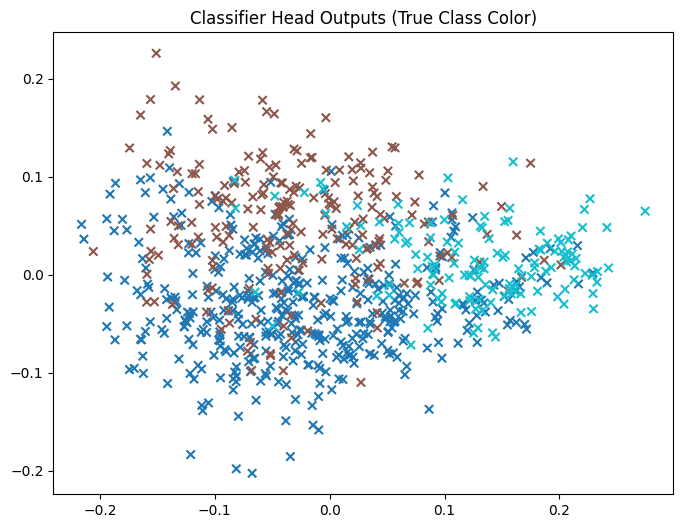

In [23]:
plt.figure(figsize=(8,6))
plt.scatter(logits_2d[:,0], logits_2d[:,1], c=labels, cmap='tab10', marker='x', label='Truth')
plt.title("Classifier Head Outputs (True Class Color)")
plt.show()